In [1]:
# ---------------------------------------------------------------------------------------------- 
# the purpose of this code is to classify mnist data with pretty tensor and ensemble
# when i write this code, i refered to https://github.com/Hvass-Labs/TensorFlow-Tutorials   and 
# https://www.youtube.com/watch?v=c62uTWdhhMw&index=40&list=PLlMkM4tgfjnLSOjrEJN31gZATbcj_MpUm
# I am not so good at English. So please be good to understand my awkward English. 
# ----------------------------------------------------------------------------------------------

In [2]:
# import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import prettytensor as pt

In [3]:
# import input_data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# parameta 
img_size = 28
img_shape = (28,28)
num_channel = 1
img_flat_size = 28*28*1
filter_size1 = 5
filter_size2 = 5
num_filters1 = 16
num_filters2 = 36
fc_size1= 128
fc_size2 = 64
num_classes = 10
training_epoch = 32
batch_size = 100
learning_rate = 0.002

In [5]:
# concatenate train and validation data
combined_images = np.concatenate([data.train.images,data.validation.images])
combined_labels = np.concatenate([data.train.labels,data.validation.labels])

In [6]:
# calculate how many data_set exist.
combined_size = len(combined_images) # 60000
train_size = combined_size # 60000

In [7]:
# function for making random_training_set
def shuffle_data():
    idx = np.random.permutation(combined_size)
    idx_train = idx[0:train_size]
    
    train_xs = combined_images
    train_ys = combined_labels
    
    return train_xs, train_ys

In [8]:
# function for plotting images
def plot_img(images, data_true,data_ensem_pred = None):
    # debugging code
    assert len(images) == len(data_true)
    
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 1, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(img_shape), cmap = "binary")
            
            if data_ensem_pred is None:
                xlabel = "True:{0}".format(data_true[i])
            else:
                xlabel = "True:{0}\nEnsemble_pred:{1}".format(data_true[i],data_ensem_pred[i])
            ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [9]:
Y_true_cls = np.argmax(data.test.labels,1)

In [10]:
# make class for using ensemble
class Model:
    def __init__(self,sess,name):
        self.sess = sess
        self.name = name
        self.build_net()
        
    def build_net(self):
        self.X = tf.placeholder(tf.float32, shape = [None,img_flat_size])
        self.Y = tf.placeholder(tf.float32, shape = [None, num_classes])
        self.X_img = tf.reshape(self.X,[-1,img_size,img_size,num_channel])
        self.pretty_X = pt.wrap(self.X_img)
        
        with pt.defaults_scope(activation_fn = tf.nn.relu):
            self.hypothesis, self.cost = self.pretty_X.\
                conv2d(kernel = filter_size1, depth = num_filters1, name = "Convol_1").\
                max_pool(kernel = 2, stride = 2).\
                conv2d(kernel = filter_size2, depth = num_filters2, name = "convol_2").\
                max_pool(kernel = 2 , stride = 2).\
                flatten().\
                fully_connected(size = fc_size1, name = "fully_1").\
                fully_connected(size = fc_size2, name = "fully_2").\
                softmax_classifier(num_classes = num_classes, labels = self.Y)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        self.is_correct = tf.equal(tf.argmax(self.hypothesis,1), tf.argmax(self.Y,1))
        self.Accuracy = tf.reduce_mean(tf.cast(self.is_correct, dtype = tf.float32))
    
    def train(self,train_data_xs,train_data_ys):
        return self.sess.run([self.cost,self.optimizer],feed_dict = {self.X:train_data_xs, self.Y:train_data_ys})
    
    def predict(self,test_xs):
        return self.sess.run([self.hypothesis], feed_dict = {self.X:test_xs})
    
    def Accuracy1(self,test_xs1,test_ys1):
        return self.sess.run([self.Accuracy], feed_dict = {self.X:test_xs1, self.Y:test_ys1})   

In [11]:
# make 5 models and save it model_saver
sess = tf.Session()
model_saver = []
num_model = 4
for m in range(num_model):
    model_saver.append(Model(sess, "Model"+ str(m)))
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
# training
print("learning started")
print("------------------------------------------------------------------")
for num_ensemble, worker in enumerate(model_saver):
    print("Ensemble:" ,num_ensemble)
    train_shuffle_xs, train_shuffle_ys = shuffle_data()
    for epoch in range(training_epoch):
        cost_val = 0
        total_batch = int(train_size/batch_size)
        for b in range(total_batch):
            batch_xs = train_shuffle_xs[100*b:100*b+100,:]
            batch_ys = train_shuffle_ys[100*b:100*b+100,:]
            c,_ = worker.train(batch_xs,batch_ys)
            cost_val += c/ total_batch
        if epoch %8 == 0:
            print("Epoch:",epoch,"cost_val:",cost_val)
    print("------------------------------------------------------------------")
print("learning_finished") 
print("------------------------------------------------------------------")

learning started
------------------------------------------------------------------
Ensemble: 0
Epoch: 0 cost_val: 0.146321868652
Epoch: 8 cost_val: 0.010544156523
Epoch: 16 cost_val: 0.006540551563
Epoch: 24 cost_val: 0.00664674890289
------------------------------------------------------------------
Ensemble: 1
Epoch: 0 cost_val: 0.156311982651
Epoch: 8 cost_val: 0.0120446715467
Epoch: 16 cost_val: 0.0077303881559
Epoch: 24 cost_val: 0.0067879781874
------------------------------------------------------------------
Ensemble: 2
Epoch: 0 cost_val: 0.156885407757
Epoch: 8 cost_val: 0.0102566180805
Epoch: 16 cost_val: 0.00555503093477
Epoch: 24 cost_val: 0.00525914835447
------------------------------------------------------------------
Ensemble: 3
Epoch: 0 cost_val: 0.184826580401
Epoch: 8 cost_val: 0.0154464795646
Epoch: 16 cost_val: 0.00758010109218
Epoch: 24 cost_val: 0.00438886451583
------------------------------------------------------------------
learning_finished
---------------

In [13]:
# make Accuracy_saver for each model.
Accuracy_saver = []

# calculate each of model's Accuracy
for num_ensemble,worker in enumerate(model_saver):
    Accuracy_val = worker.Accuracy1(data.test.images,data.test.labels)
    Accuracy_saver.append(Accuracy_val)

print(Accuracy_saver)

[[0.991], [0.99129999], [0.99220002], [0.9903]]


In [14]:
# for calculating total Accuracy, we need to make total_prediction_value which is result from summing up all value 
# of prediction and dividing its number of models

# make prediction_saver for each model
prediction_saver = []

# append hypothesis_val 
for num_ensemble, worker in enumerate(model_saver):
    hypothesis_mean = 0
    hypothesis_val = worker.predict(data.test.images)
    prediction_saver.append(hypothesis_val)

# make ensemble's predicion 
prediction_saver = np.array(prediction_saver)
prediction_ensem = tf.reduce_mean(prediction_saver, axis =0)
prediction_ensem_cls = tf.argmax(prediction_ensem,2)
prediction_ensem_cls = tf.reshape(prediction_ensem_cls,[-1])

In [15]:
# calculate Accuracy
is_correct_ensem = tf.equal(Y_true_cls,prediction_ensem_cls)
Accuracy_ensem = tf.reduce_mean(tf.cast(is_correct_ensem, dtype = tf.float32))
Ensemble_Accuracy,correct,prediction_ensem_cls1 = sess.run([Accuracy_ensem,is_correct_ensem,prediction_ensem_cls])
print("Ensemble_Accuracy\n{0}".format(Ensemble_Accuracy))

Ensemble_Accuracy
0.9943000078201294


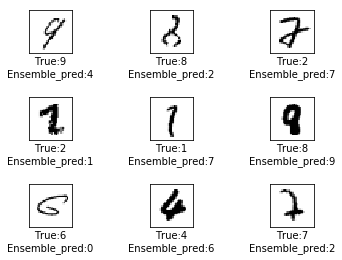

In [16]:
# plot examples of error
def plot_examples_error():
    incorrect = (correct == False)
    
    q = data.test.images[incorrect]
    w = Y_true_cls[incorrect]
    e = prediction_ensem_cls1[incorrect]
    
    q = q[0:9]
    w = w[0:9]
    e = e[0:9]
    
    plot_img(q,w,e)

plot_examples_error()

[[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   0    1 1028    0    0    0    0    3    0    0]
 [   0    0    0 1007    0    2    0    1    0    0]
 [   0    0    0    0  979    0    1    0    0    2]
 [   1    0    0    4    0  885    1    0    0    1]
 [   2    2    0    0    1    0  952    0    1    0]
 [   0    2    1    0    0    0    0 1024    1    0]
 [   2    0    2    1    0    1    0    0  965    3]
 [   0    0    0    0    7    4    0    3    1  994]]


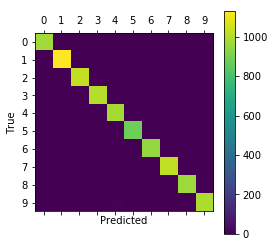

In [17]:
# create confusion matrix
def plot_confusion_matrix():
    data_true1 = Y_true_cls
    data_pred1 = prediction_ensem_cls1
    
    cm = confusion_matrix(data_true1,data_pred1)
    
    print(cm)
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

plot_confusion_matrix()